In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

import tensorflow as tf
import tensorflow.keras as keras
import keras.metrics as metrics
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold

import data_visualisation as dv
import data_augmentation as da

import models.cnn as cnn
import models.resnet as resnet


2024-06-03 17:22:39.345681: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 17:22:39.866859: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-06-03 17:22:39.866918: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-06-03 17:22:39.866924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Augment fns

In [2]:
def augment_ecg_signal(signal,):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(2 ,3), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0.1, 0.2))
    return signal

def augment_ecg_signal_batch(signals, labels, batch_size):
    while True:
        
        indices = np.random.randint(0, signals.shape[0], size=batch_size)
        batch = signals[indices]
        batch_labels = labels[indices]
        
        augmented_batch = np.array([augment_ecg_signal(sample) for sample in batch])
        
        yield (augmented_batch, batch_labels)

# Load Data

In [3]:
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

(8386, 100, 12) (8386,)
(2159, 100, 12) (2159,)


In [4]:
# smote data
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s_resampled_per_fold.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(folds_train.shape)
print(X_train_resampled.shape, Y_train_resampled.shape)
print(folds_train_resampled.shape)
print(X_test.shape, Y_test.shape)


# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

(8386, 100, 12) (8386,)
(8386,)
(12544, 100, 12) (12544,)
(12544,)
(2159, 100, 12) (2159,)


In [5]:
# deep smote data
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s_deep_resampled_per_fold.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(folds_train.shape)
print(X_train_resampled_deep.shape, Y_train_resampled_deep.shape)
print(folds_train_resampled_deep.shape)
print(X_test.shape, Y_test.shape)


# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)
Y_train_resampled = np.where(Y_train_resampled == 1, True, False)

(8386, 100, 12) (8386,)
(8386,)
(12544, 100, 12) (12544,)
(12544,)
(2159, 100, 12) (2159,)


# Resnet K-Fold

In [6]:
def k_fold_finetune_resnet(k, X_train, Y_train, folds_train, X_val, Y_val, folds_val, freeze_layers=8, batch_size=32, epochs=5, weights_path=None, learning_rate=0.001, num_classes=1, name="b_model.h5"):
    """Carries out k-fold cross validation for fine-tuning a ResNet model on the given data.
    
    Args:
        k (int): The number of folds to use for cross validation.
        X_train (numpy.ndarray): The training data.
        Y_train (numpy.ndarray): The training labels.
        freeze_layers (int): The number of layers to freeze in the ResNet model.
        batch_size (int): The batch size to use for training.
        epochs (int): The number of epochs to train for.
        weights_path (str): The path to the weights file to save the model to.
        learning_rate (float): The learning rate to use for training.
        num_classes (int): The number of classes in the data.
    """
    
    X_input = keras.Input(shape=X_train.shape[1:])
    
    layers_to_freeze_substrings = [f"_{i}_" for i in range(1, freeze_layers)]
    
    final_history = None
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    val_aucs = []
    
    for i in range(k):
    
        train_index = np.where(folds_train != i)[0]
        val_index = np.where(folds_val == i)[0]
        
        X_train_fold, X_val_fold = X_train[train_index], X_val[val_index]
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_val[val_index]
        
        print(f"\nTraining on fold {i+1}")
        
        # make model
        out, _ = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)
        fine_tuned_model = keras.Model(inputs=X_input, outputs=out)
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        fine_tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

        # load + freeze weights
        if weights_path:
            fine_tuned_model.load_weights(weights_path, by_name=True) # 'model-weights/resnet10_simclr_model.h5'
            for layer in fine_tuned_model.layers:
                if any([text in layer.name for text in layers_to_freeze_substrings]):
                    layer.trainable = False
                
        # train
        data_generator = augment_ecg_signal_batch(X_train_fold, Y_train_fold, batch_size=batch_size)
        history = fine_tuned_model.fit(data_generator, validation_data=(X_val_fold, Y_val_fold), epochs=epochs, batch_size=batch_size, steps_per_epoch=X_train.shape[0]//batch_size, verbose=0)
        
        # evaluate
        val_loss, val_accuracy, val_precision, val_recall = fine_tuned_model.evaluate(X_val_fold, Y_val_fold, batch_size=32, verbose=0)
        y_pred = fine_tuned_model.predict(X_val_fold)
        val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
        val_auc = roc_auc_score(Y_val_fold, y_pred)
        
        test_loss, test_accuracy, test_precision, test_recall = fine_tuned_model.evaluate(X_test, Y_test, batch_size=32, verbose=0)
        y_pred = fine_tuned_model.predict(X_test)
        test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
        test_auc = roc_auc_score(Y_test, y_pred)
        
        
        
        print(f"Val Accuracy: {val_accuracy}, Val Precision: {val_precision}, Val Recall: {val_recall}, Val AUC: {val_auc}, Val F1 Score: {val_f1}")
        print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test AUC: {test_auc},Test F1 Score: {test_f1}")
        
        if not val_f1s or val_f1 > max(val_f1s):
            fine_tuned_model.save_weights(f'model-weights/fine-tuned/{name}')
            final_history = history
        
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)
        
    # plot training history
    plt.plot(final_history.history['accuracy'])
    plt.plot(final_history.history['val_accuracy'])
    plt.plot(final_history.history['loss'])
    plt.plot(final_history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')   
    plt.legend(['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'], loc='upper left')
    plt.show()
    
    # print final results
    print("K-Fold Results:")
    print(f"Acuracy: {np.mean(val_accuracies)} \t +/- {np.std(val_accuracies)}")
    print(f"Precision: {np.mean(val_precisions)} \t +/- {np.std(val_precisions)}")
    print(f"Recall: {np.mean(val_recalls)} \t +/- {np.std(val_recalls)}")
    print(f"AUC: {np.mean(val_aucs)} \t +/- {np.std(val_aucs)}")
    print(f"F1: {np.mean(val_f1s)} \t +/- {np.std(val_f1s)}")
    
    # load best model
    fine_tuned_model = keras.Model(inputs=X_input, outputs=out)
    fine_tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
    fine_tuned_model.load_weights(f'model-weights/fine-tuned/{name}')
    
    # evaluate on test set
    print("\n") # spacer
    test_loss, test_accuracy, test_precision, test_recall = fine_tuned_model.evaluate(X_test, Y_test, batch_size=32)
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    y_pred = fine_tuned_model.predict(X_test)
    test_auc = roc_auc_score(Y_test, y_pred)
    print("\nTest Performance:")
    print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test AUC: {test_auc}, Test F1 Score: {test_f1}")
    

# No Pre-training


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9605026841163635, Val Precision: 0.8672199249267578, Val Recall: 0.9457013607025146, Val AUC: 0.9936155011578238, Val F1 Score: 0.9047619105502384
Test Accuracy: 0.9680407643318176, Test Precision: 0.9281663298606873, Test Recall: 0.9406130313873291, Test AUC: 0.9967279646676357,Test F1 Score: 0.9343482310066521

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9506173133850098, Val Precision: 0.9105058312416077, Val Recall: 0.8897338509559631, Val AUC: 0.9780430283486548, Val F1 Score: 0.9000000028435647
Test Accuracy: 0.9647985100746155, Test Precision: 0.9207547307014465, Test Recall: 0.9348658919334412, Test AUC: 0.994328940192905,Test F1 Score: 0.9277566567964479

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.920604944229126, Val Precision: 0.8504983186721802, Val Recall: 0.8677965998649597, Val AUC: 0.96187218162

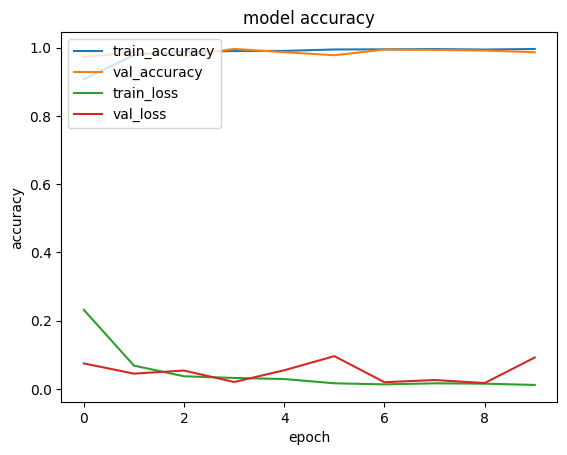

K-Fold Results:
Acuracy: 0.9550228416919708 	 +/- 0.023891085101799932
Precision: 0.9254277944564819 	 +/- 0.04953458128465773
Recall: 0.9041850566864014 	 +/- 0.047655296556985395
AUC: 0.9836412838763906 	 +/- 0.015485853220139878
F1: 0.9135116827074491 	 +/- 0.03563197038888848


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9555349946022034, Test Precision: 0.8561872839927673, Test Recall: 0.9808428883552551, Test AUC: 0.9837357843171675, Test F1 Score: 0.9142857000885569


In [16]:
# no smote
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path=None, learning_rate=0.001, num_classes=1, name="resnet10_no_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9542190432548523, Val Precision: 0.8863636255264282, Val Recall: 0.8823529481887817, Val AUC: 0.9610596241252983, Val F1 Score: 0.8843537396246153
Test Accuracy: 0.962945818901062, Test Precision: 0.88908451795578, Test Recall: 0.967432975769043, Test AUC: 0.991904170089665,Test F1 Score: 0.926605522246305

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9382715821266174, Val Precision: 0.875, Val Recall: 0.8783270120620728, Val AUC: 0.9755691389517256, Val F1 Score: 0.8766603494580797
Test Accuracy: 0.9462714195251465, Test Precision: 0.862500011920929, Test Recall: 0.9252873659133911, Test AUC: 0.9888433659366611,Test F1 Score: 0.8927911383929052

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9404537081718445, Val Precision: 0.9027777910232544, Val Recall: 0.8813559412956238, Val AUC: 0.9639269609258724, Val F1 Scor

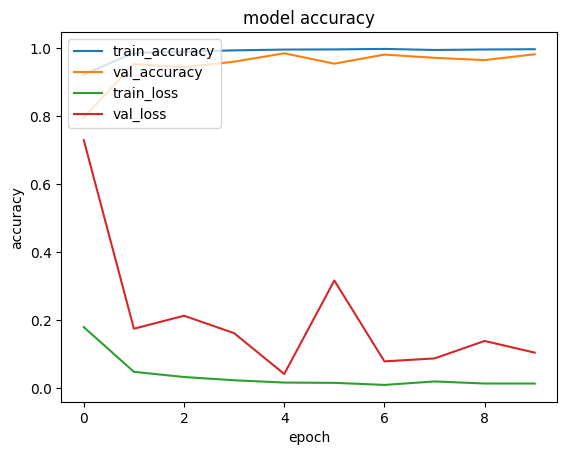

K-Fold Results:
Acuracy: 0.9552104622125626 	 +/- 0.019592927651866664
Precision: 0.9102562516927719 	 +/- 0.03175874188654669
Recall: 0.9190751761198044 	 +/- 0.04989957842173844
AUC: 0.979487584388123 	 +/- 0.01601111954864235
F1: 0.9138772091910907 	 +/- 0.031199855146125978


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9481241106987, Test Precision: 0.8740875720977783, Test Recall: 0.9176245331764221, Test AUC: 0.991569476919044, Test F1 Score: 0.8953270985226575


In [17]:
# smote
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path=None, learning_rate=0.001, num_classes=1, name="resnet10_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.8662477731704712, Val Precision: 0.7117646932601929, Val Recall: 0.5475113391876221, Val AUC: 0.8599058539773907, Val F1 Score: 0.6189258436624848
Test Accuracy: 0.8522464036941528, Test Precision: 0.8103975653648376, Test Recall: 0.507662832736969, Test AUC: 0.8362554621691393,Test F1 Score: 0.6242638414275146

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7758784294128418, Val Precision: 0.8292682766914368, Val Recall: 0.1292775720357895, Val AUC: 0.7105356885017086, Val F1 Score: 0.22368421817135178
Test Accuracy: 0.7698008418083191, Test Precision: 0.8205128312110901, Test Recall: 0.061302680522203445, Test AUC: 0.7856418970315291,Test F1 Score: 0.11408199399267382

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7684310078620911, Val Precision: 0.6068376302719116, Val Recall: 0.4813559353351593, Val AUC: 0.722029

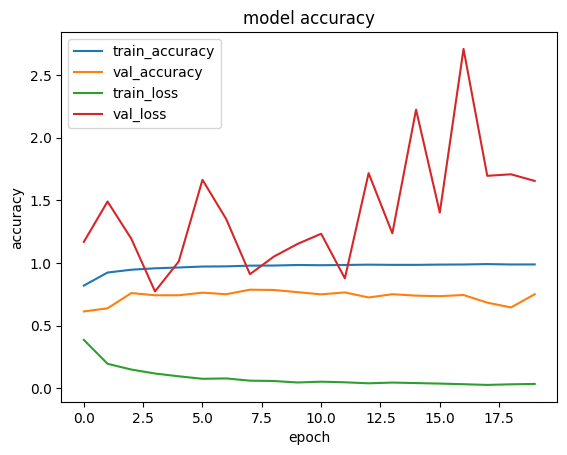

K-Fold Results:
Acuracy: 0.7791413813829422 	 +/- 0.04495708351753779
Precision: 0.6014806283637881 	 +/- 0.2133020002128203
Recall: 0.3084369017742574 	 +/- 0.20501959627310629
AUC: 0.7134087697044207 	 +/- 0.1201388293450086
F1: 0.37765609044798065 	 +/- 0.19935239550485553


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.8615099787712097, Test Precision: 0.7107750177383423, Test Recall: 0.7203065156936646, Test AUC: 0.9086685531190829, Test F1 Score: 0.7155090251795675


In [16]:
# deep smote
k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, batch_size=32, epochs=20, weights_path=None, learning_rate=0.001, num_classes=1, name="resnet10_no_pretrain__deep_smote_brugada.h5")

# Transfer Learning


Training on fold 1


2024-06-03 17:22:51.990682: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-03 17:22:52.044151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-03 17:22:52.044356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-03 17:22:52.044819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9829443693161011, Val Precision: 0.9764150977134705, Val Recall: 0.9366515874862671, Val AUC: 0.9988447097333205, Val F1 Score: 0.9561200959635071
Test Accuracy: 0.9601667523384094, Test Precision: 0.9113207459449768, Test Recall: 0.9252873659133911, Test AUC: 0.9863302415174005,Test F1 Score: 0.9182509508404928

Training on fold 2
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.9477682709693909, Val Precision: 0.9561403393745422, Val Recall: 0.8288973569869995, Val AUC: 0.944664773547673, Val F1 Score: 0.8879837124242884
Test Accuracy: 0.9680407643318176, Test Precision: 0.9557344317436218, Test Recall: 0.9099617004394531, Test AUC: 0.9817071458162183,Test F1 Score: 0.9322865751566252

Training on fold 3
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.8979206085205078, Val Precision: 0.8912134170532227, Val Recall: 0.7220339179039001, Val AUC: 0.9313526001288402, Val F1 Score

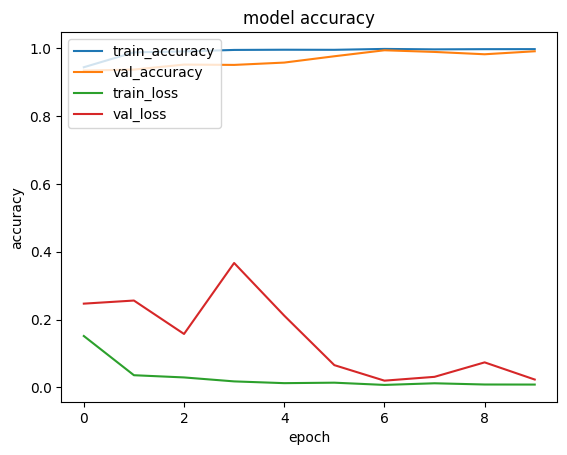

K-Fold Results:
Acuracy: 0.9501484110951424 	 +/- 0.031210351991314396
Precision: 0.9347561597824097 	 +/- 0.04342580673155319
Recall: 0.8724537938833237 	 +/- 0.0870048433371881
AUC: 0.9775633687105822 	 +/- 0.024410407436563555
F1: 0.9008017133838784 	 +/- 0.05898993567311808


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9745252728462219, Test Precision: 0.9533980488777161, Test Recall: 0.9406130313873291, Test AUC: 0.9962856079596121, Test F1 Score: 0.9469623892043331


In [7]:
# No smote
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='model-weights/resnet_feature_model_ptbxl_classifier.h5', learning_rate=0.001, num_classes=1, name="resnet10_no_smote_transfer.h5")


Training on fold 1
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.9838420152664185, Val Precision: 0.9356223344802856, Val Recall: 0.9864253401756287, Val AUC: 0.9945909107031563, Val F1 Score: 0.9603524321849648
Test Accuracy: 0.9638721346855164, Test Precision: 0.8950178027153015, Test Recall: 0.9636015295982361, Test AUC: 0.9895566368719529,Test F1 Score: 0.9280442839692022

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9553655982017517, Val Precision: 0.9615384340286255, Val Recall: 0.855513334274292, Val AUC: 0.9633344563700246, Val F1 Score: 0.9054325981003917
Test Accuracy: 0.958314061164856, Test Precision: 0.9302788972854614, Test Recall: 0.8946360349655151, Test AUC: 0.986828770505808,Test F1 Score: 0.9121093913709046

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9376181364059448, Val Precision: 0.8989546895027161, Val Recall: 0.8745762705802917, Val AUC: 0.970935424395

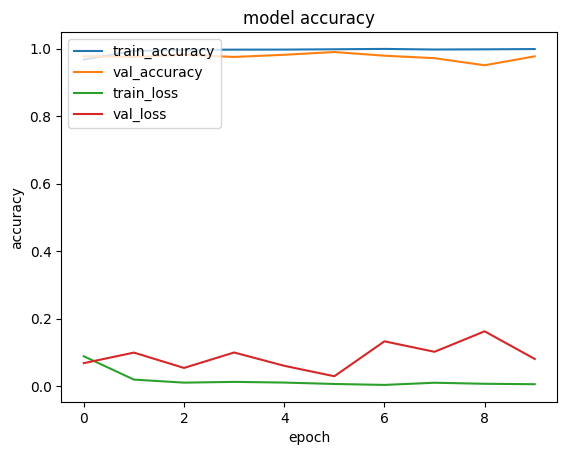

K-Fold Results:
Acuracy: 0.9564328044652939 	 +/- 0.018408873824631366
Precision: 0.9068304300308228 	 +/- 0.0738103798476
Recall: 0.9292140752077103 	 +/- 0.060370699119417615
AUC: 0.9857593748566027 	 +/- 0.012768943091836168
F1: 0.9138929166596237 	 +/- 0.0362254050245637


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.9597035646438599, Test Precision: 0.8863232731819153, Test Recall: 0.9559386968612671, Test AUC: 0.989928193101576, Test F1 Score: 0.9198156706708471


In [8]:
# SMOTE
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='model-weights/resnet_feature_model_ptbxl_classifier.h5', learning_rate=0.001, num_classes=1, name="resnet10_smote_transfer.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.8213644623756409, Val Precision: 0.7115384340286255, Val Recall: 0.16742081940174103, Val AUC: 0.849432235638678, Val F1 Score: 0.271062275517284
Test Accuracy: 0.7721167206764221, Test Precision: 0.720588207244873, Test Recall: 0.09386973083019257, Test AUC: 0.8463957290342816,Test F1 Score: 0.16610169265058594

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7663817405700684, Val Precision: 0.6734693646430969, Val Recall: 0.12547528743743896, Val AUC: 0.7223131347162729, Val F1 Score: 0.21153846361908876
Test Accuracy: 0.8360351920127869, Test Precision: 0.942105233669281, Test Recall: 0.34291186928749084, Test AUC: 0.8584727693168279,Test F1 Score: 0.5028089758489841

Training on fold 3
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.7948960065841675, Val Precision: 0.6666666865348816, Val Recall: 0.5288135409355164, Val AUC: 0.7793811

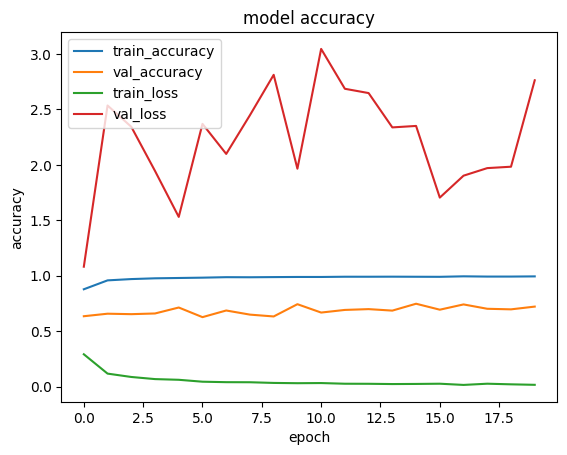

K-Fold Results:
Acuracy: 0.7763475254178047 	 +/- 0.0339385008440797
Precision: 0.5967136211693287 	 +/- 0.0959815351051665
Recall: 0.3744742553681135 	 +/- 0.19811688789530388
AUC: 0.7382874049545779 	 +/- 0.07379841675127746
F1: 0.4275611676715465 	 +/- 0.14689981306038993


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.7336729764938354, Test Precision: 0.4626234173774719, Test Recall: 0.6283524632453918, Test AUC: 0.7655591365384299, Test F1 Score: 0.5329000741944422


In [9]:
# Deep SMOTE
k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=20, weights_path='model-weights/resnet_feature_model_ptbxl_classifier.h5', learning_rate=0.001, num_classes=1, name="resnet10_deep_smote_transfer.h5")

# SimCLR


Training on fold 1


68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9533213376998901, Val Precision: 0.9941520690917969, Val Recall: 0.7692307829856873, Val AUC: 0.9983126681631392, Val F1 Score: 0.8673469560094386
Test Accuracy: 0.9587771892547607, Test Precision: 0.9253438115119934, Test Recall: 0.9022988677024841, Test AUC: 0.9909469008114553,Test F1 Score: 0.9136760515153094

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9515669345855713, Val Precision: 0.9380165338516235, Val Recall: 0.8631178736686707, Val AUC: 0.9803388362131202, Val F1 Score: 0.8990099048506991
Test Accuracy: 0.9592403769493103, Test Precision: 0.8767361044883728, Test Recall: 0.967432975769043, Test AUC: 0.983347844505766,Test F1 Score: 0.9198542884266909

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9319470524787903, Val Precision: 0.8562300205230713, Val Recall: 0.9084745645523071, Val AUC: 0.951027389652798, Val F1 Score: 

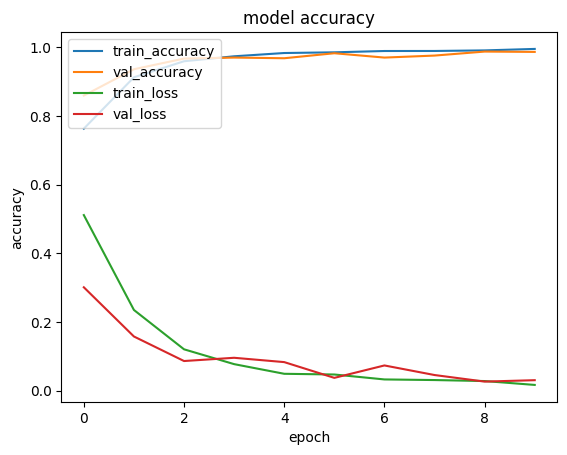

K-Fold Results:
Acuracy: 0.9523432084492275 	 +/- 0.021904541172847767
Precision: 0.9275333285331726 	 +/- 0.038042086168838835
Recall: 0.8791363835334778 	 +/- 0.0902178555994823
AUC: 0.9846635770395592 	 +/- 0.015730809577934227
F1: 0.8994340286362966 	 +/- 0.04796246312624626


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9592403769493103, Test Precision: 0.8793706297874451, Test Recall: 0.9636015295982361, Test AUC: 0.9877743372256043, Test F1 Score: 0.919561242020496


In [18]:
# PTB-XL
# No SMOTE
k_fold_finetune_resnet(7, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1, name="resnet10_ptbxl_SimCLR_no_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9694793820381165, Val Precision: 0.9746192693710327, Val Recall: 0.8687782883644104, Val AUC: 0.9978160960309699, Val F1 Score: 0.9186602825831204
Test Accuracy: 0.9638721346855164, Test Precision: 0.9051094651222229, Test Recall: 0.9501915574073792, Test AUC: 0.9950392854885936,Test F1 Score: 0.9271027847718688

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.94017094373703, Val Precision: 0.8472222089767456, Val Recall: 0.927756667137146, Val AUC: 0.9889926360879819, Val F1 Score: 0.8856624306940781
Test Accuracy: 0.9518295526504517, Test Precision: 0.857876718044281, Test Recall: 0.959770143032074, Test AUC: 0.9872863405397688,Test F1 Score: 0.9059674659726527

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9413988590240479, Val Precision: 0.95686274766922, Val Recall: 0.8271186351776123, Val AUC: 0.9691094475420396

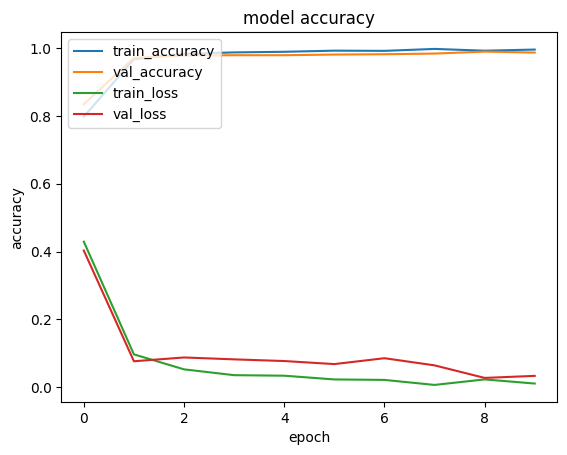

K-Fold Results:
Acuracy: 0.9608869254589081 	 +/- 0.019153274190385493
Precision: 0.9509717524051666 	 +/- 0.04317763465374885
Recall: 0.8959211781620979 	 +/- 0.04839096331079977
AUC: 0.9843275123049443 	 +/- 0.012465602696666463
F1: 0.9214512453032185 	 +/- 0.03382350672355207


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.960629940032959, Test Precision: 0.9309664964675903, Test Recall: 0.9042145609855652, Test AUC: 0.9871938903283035, Test F1 Score: 0.9173955435916975


In [14]:
# BARD
# NO SMOTE
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=7, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0003, num_classes=1)


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9605026841163635, Val Precision: 0.9004524946212769, Val Recall: 0.9004524946212769, Val AUC: 0.9936712388461285, Val F1 Score: 0.9004524946212769
Test Accuracy: 0.9495136737823486, Test Precision: 0.8494077920913696, Test Recall: 0.961685836315155, Test AUC: 0.9833490147616072,Test F1 Score: 0.9020664973888827

Training on fold 2
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.9278252720832825, Val Precision: 0.8303886651992798, Val Recall: 0.8935361504554749, Val AUC: 0.9739615921451605, Val F1 Score: 0.8608058594506818
Test Accuracy: 0.9550718069076538, Test Precision: 0.867012083530426, Test Recall: 0.961685836315155, Test AUC: 0.9863665194484819,Test F1 Score: 0.911898276469533

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9395084977149963, Val Precision: 0.8888888955116272, Val Recall: 0.8949152827262878, Val AUC: 0.9619832507719

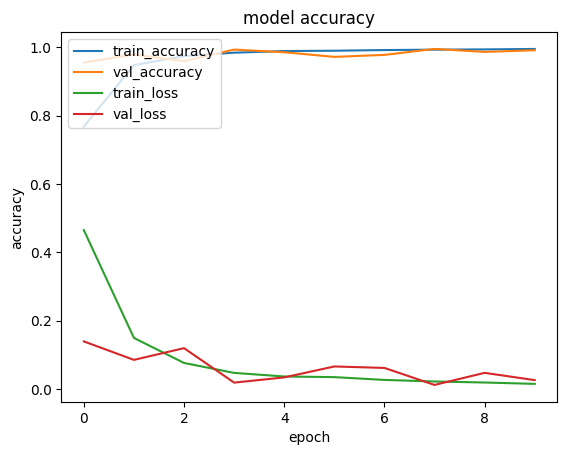

K-Fold Results:
Acuracy: 0.9540170356631279 	 +/- 0.02070510891786806
Precision: 0.9053485244512558 	 +/- 0.042582010462747524
Recall: 0.9131535887718201 	 +/- 0.0674687719816852
AUC: 0.9856975296430306 	 +/- 0.013839340507715701
F1: 0.907859245666982 	 +/- 0.0450160110654207


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.966651201248169, Test Precision: 0.8892733454704285, Test Recall: 0.984674334526062, Test AUC: 0.9889481038344603, Test F1 Score: 0.9345454507721357


In [15]:
# SMOTE
# PTB-XL
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1)


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9730700254440308, Val Precision: 0.9321267008781433, Val Recall: 0.9321267008781433, Val AUC: 0.9954801801847452, Val F1 Score: 0.9321267008781433
Test Accuracy: 0.9448819160461426, Test Precision: 0.8386554718017578, Test Recall: 0.9559386968612671, Test AUC: 0.9774860329965337,Test F1 Score: 0.8934646426796466

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9439696073532104, Val Precision: 0.8777777552604675, Val Recall: 0.9011406898498535, Val AUC: 0.9773932714058815, Val F1 Score: 0.889305807227401
Test Accuracy: 0.9462714195251465, Test Precision: 0.8274193406105042, Test Recall: 0.982758641242981, Test AUC: 0.9800775645571635,Test F1 Score: 0.8984238180644919

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9413988590240479, Val Precision: 0.8794788122177124, Val Recall: 0.9152542352676392, Val AUC: 0.96089921585

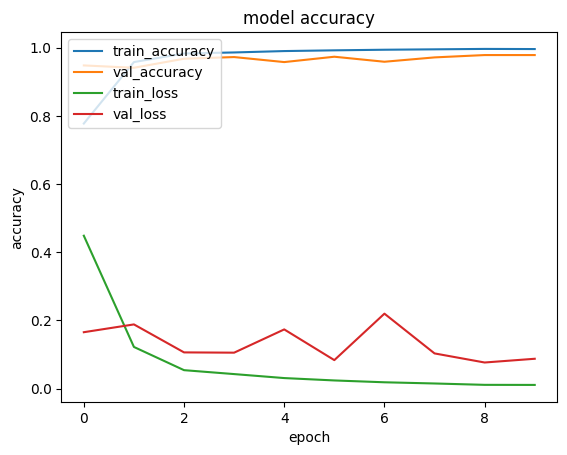

K-Fold Results:
Acuracy: 0.9564163684844971 	 +/- 0.014633546105888596
Precision: 0.9111796393990517 	 +/- 0.044727272706775574
Recall: 0.9179079979658127 	 +/- 0.060474228140907034
AUC: 0.9839292242470787 	 +/- 0.012683247435261585
F1: 0.912526120276388 	 +/- 0.03153274408421686


68/68 [==============================] - 1s 3ms/step

Test Performance:
Test Accuracy: 0.9624826312065125, Test Precision: 0.8916518688201904, Test Recall: 0.961685836315155, Test AUC: 0.9883846256468589, Test F1 Score: 0.9253456299867325


In [16]:
# SMOTE
# BARD
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1)


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.8976660966873169, Val Precision: 0.7955800890922546, Val Recall: 0.651583731174469, Val AUC: 0.9356533723834956, Val F1 Score: 0.7164179143219666
Test Accuracy: 0.8374247550964355, Test Precision: 0.6904231905937195, Test Recall: 0.5938697457313538, Test AUC: 0.8817011775114277,Test F1 Score: 0.6385170128213487

Training on fold 2
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.7568851113319397, Val Precision: 0.5087282061576843, Val Recall: 0.7756654024124146, Val AUC: 0.8163474033787359, Val F1 Score: 0.6144578517284168
Test Accuracy: 0.7012505531311035, Test Precision: 0.4295532703399658, Test Recall: 0.7183908224105835, Test AUC: 0.7602169186227493,Test F1 Score: 0.537634418082659

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.7372400760650635, Val Precision: 0.5255255103111267, Val Recall: 0.5932203531265259, Val AUC: 0.76601061821

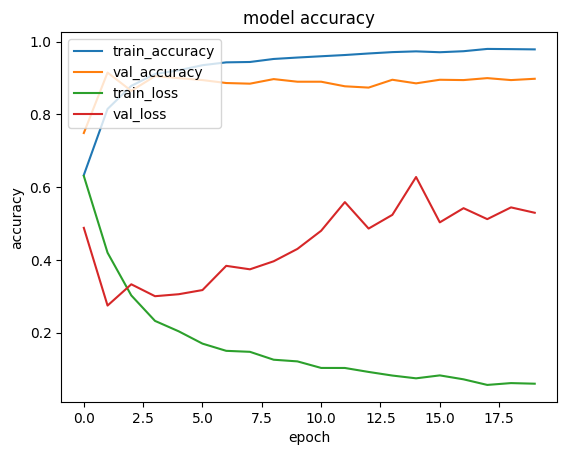

K-Fold Results:
Acuracy: 0.7642235457897186 	 +/- 0.055467524364266836
Precision: 0.5432984456419945 	 +/- 0.1118012773414976
Recall: 0.7340260222554207 	 +/- 0.10542568105441988
AUC: 0.8260891643258189 	 +/- 0.04781558568118828
F1: 0.6122348295579882 	 +/- 0.05977433641937083


68/68 [==============================] - 1s 3ms/step

Test Performance:
Test Accuracy: 0.8374247550964355, Test Precision: 0.6904231905937195, Test Recall: 0.5938697457313538, Test AUC: 0.8817011775114277, Test F1 Score: 0.6385170128213487


In [17]:
# Deep SMOTE
# PTB-XL
k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=20, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1, name="resnet10_ptbxl_deep_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9138240814208984, Val Precision: 0.8140703439712524, Val Recall: 0.733031690120697, Val AUC: 0.9452858583350646, Val F1 Score: 0.7714285767436566
Test Accuracy: 0.8480778336524963, Test Precision: 0.7449495196342468, Test Recall: 0.5651341080665588, Test AUC: 0.8798229168860897,Test F1 Score: 0.6427015397054605

Training on fold 2
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.8328585028648376, Val Precision: 0.6355140209197998, Val Recall: 0.7756654024124146, Val AUC: 0.9072459931655196, Val F1 Score: 0.69863013961966
Test Accuracy: 0.7378416061401367, Test Precision: 0.4715026021003723, Test Recall: 0.6973180174827576, Test AUC: 0.7797180619627063,Test F1 Score: 0.5625966110212155

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7854442596435547, Val Precision: 0.625, Val Recall: 0.5762711763381958, Val AUC: 0.7788324410778151, Val F1 

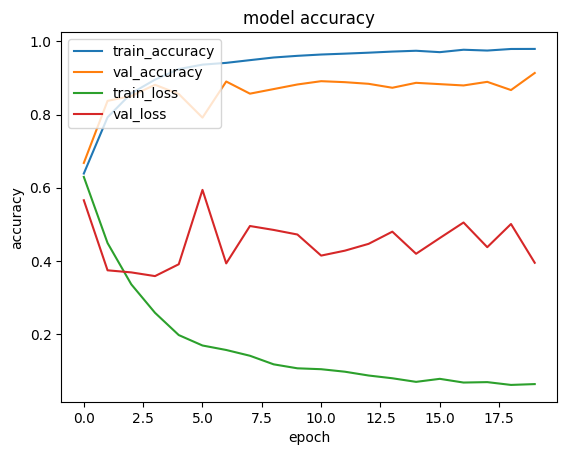

K-Fold Results:
Acuracy: 0.8363684117794037 	 +/- 0.043574728759249344
Precision: 0.7167941704392433 	 +/- 0.09911860024255859
Recall: 0.6214459128677845 	 +/- 0.10550238855876044
AUC: 0.8541748629496269 	 +/- 0.05292978176529819
F1: 0.6557626201587627 	 +/- 0.07049634707085385


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.8480778336524963, Test Precision: 0.7449495196342468, Test Recall: 0.5651341080665588, Test AUC: 0.8798229168860897, Test F1 Score: 0.6427015397054605


In [18]:
# Deep SMOTE
# BARD
k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=20, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1, name="resnet10_bard_deep_smote_brugada.h5")

# MoCo v2


Training on fold 1
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9542190432548523, Val Precision: 0.8761062026023865, Val Recall: 0.8959276080131531, Val AUC: 0.9894149062846778, Val F1 Score: 0.8859060473461146
Test Accuracy: 0.9550718069076538, Test Precision: 0.8708551526069641, Test Recall: 0.9559386968612671, Test AUC: 0.9836632284550049,Test F1 Score: 0.91141552724228

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9316239356994629, Val Precision: 0.9321267008781433, Val Recall: 0.7832699418067932, Val AUC: 0.9627039514848148, Val F1 Score: 0.8512396591969764
Test Accuracy: 0.9620194435119629, Test Precision: 0.9166666865348816, Test Recall: 0.9272030591964722, Test AUC: 0.9834420501009932,Test F1 Score: 0.9219047690177449

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9187145829200745, Val Precision: 0.8884758353233337, Val Recall: 0.810169517993927, Val AUC: 0.946171446342

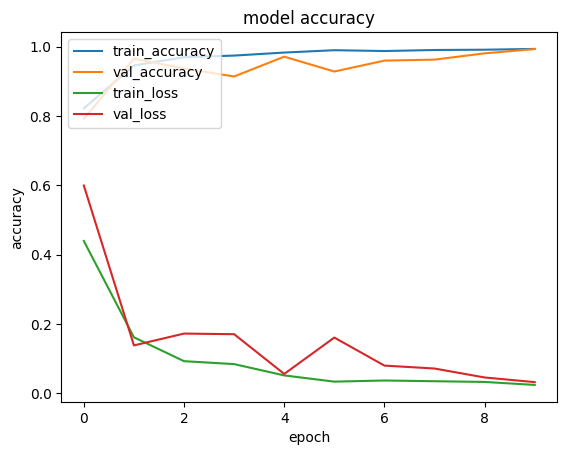

K-Fold Results:
Acuracy: 0.9473043233156204 	 +/- 0.031379172725056886
Precision: 0.897677406668663 	 +/- 0.054913521918609334
Recall: 0.9053474068641663 	 +/- 0.07087380807589685
AUC: 0.9743871175612816 	 +/- 0.017750832684060493
F1: 0.8994550431619386 	 +/- 0.04840733849475024


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.946734607219696, Test Precision: 0.8397328853607178, Test Recall: 0.9636015295982361, Test AUC: 0.9841845774323184, Test F1 Score: 0.8974130212071015


In [20]:
# NO SMOTE
# PTB-XL
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=10, weights_path='model-weights/test_moco_model.h5', learning_rate=0.0005, num_classes=1, name="resnet10_ptbxl_moco_no_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9326750636100769, Val Precision: 0.929411768913269, Val Recall: 0.7149321436882019, Val AUC: 0.9613687149422608, Val F1 Score: 0.80818415566969
Test Accuracy: 0.9351551532745361, Test Precision: 0.873046875, Test Recall: 0.8563218116760254, Test AUC: 0.967234591826465,Test F1 Score: 0.864603467656226

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9259259104728699, Val Precision: 0.9468598961830139, Val Recall: 0.7452471256256104, Val AUC: 0.9388265870914955, Val F1 Score: 0.8340425362059194
Test Accuracy: 0.9383974075317383, Test Precision: 0.843033492565155, Test Recall: 0.9157088398933411, Test AUC: 0.9771934690362007,Test F1 Score: 0.877869608550276

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9035916924476624, Val Precision: 0.8814229369163513, Val Recall: 0.7559322118759155, Val AUC: 0.9569584823511118, Val F

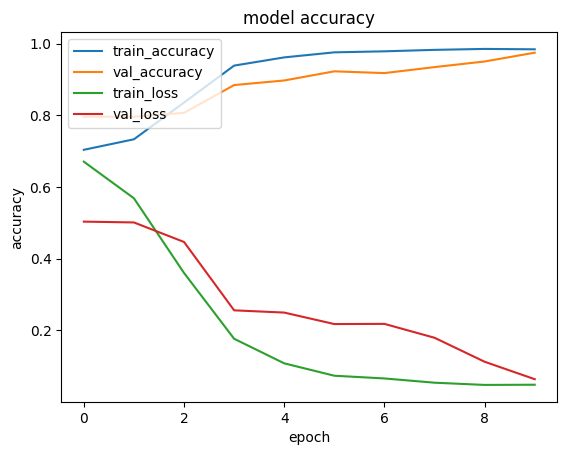

K-Fold Results:
Acuracy: 0.9269064739346504 	 +/- 0.021699992716573798
Precision: 0.9094995409250259 	 +/- 0.044785541800677155
Recall: 0.7956976518034935 	 +/- 0.09215751443214334
AUC: 0.9632544394355219 	 +/- 0.01703180624714246
F1: 0.8442176847453002 	 +/- 0.04512777158021462


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.9462714195251465, Test Precision: 0.8980392217636108, Test Recall: 0.8773946166038513, Test AUC: 0.9753403689114515, Test F1 Score: 0.887596892260454


In [10]:
# NO SMOTE
# BARD

k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=10, weights_path='model-weights/test_moco_BARD_6.h5', learning_rate=0.0001, num_classes=1)


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9802513718605042, Val Precision: 0.9383260011672974, Val Recall: 0.9638009071350098, Val AUC: 0.9971117743333012, Val F1 Score: 0.950892863316433
Test Accuracy: 0.9564613103866577, Test Precision: 0.8702422380447388, Test Recall: 0.9636015295982361, Test AUC: 0.9890230002083056,Test F1 Score: 0.9145454661917093

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9420702457427979, Val Precision: 0.9316239356994629, Val Recall: 0.8288973569869995, Val AUC: 0.9437647398565723, Val F1 Score: 0.8772635937038209
Test Accuracy: 0.9675775766372681, Test Precision: 0.9139193892478943, Test Recall: 0.9559386968612671, Test AUC: 0.993957383963282,Test F1 Score: 0.934456915724324

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9177693724632263, Val Precision: 0.8270440101623535, Val Recall: 0.8915254473686218, Val AUC: 0.972979096785

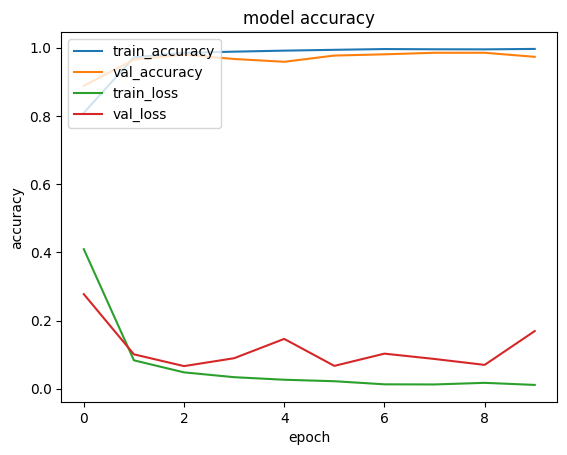

K-Fold Results:
Acuracy: 0.9534400701522827 	 +/- 0.020120794818621678
Precision: 0.895521953701973 	 +/- 0.052302830734009556
Recall: 0.9277016520500183 	 +/- 0.04636124023895939
AUC: 0.983462003345432 	 +/- 0.01736594515023358
F1: 0.9098423875644978 	 +/- 0.034288208131423095


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9624826312065125, Test Precision: 0.8916518688201904, Test Recall: 0.961685836315155, Test AUC: 0.9883846256468589, Test F1 Score: 0.9253456299867325


In [22]:
# SMOTE
# PTB-XL
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=10, weights_path='model-weights/test_moco_model.h5', learning_rate=0.0005, num_classes=1, name="moco_bard_no_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9676840305328369, Val Precision: 0.9111111164093018, Val Recall: 0.9276018142700195, Val AUC: 0.98839896023876, Val F1 Score: 0.919282516026694
Test Accuracy: 0.9509031772613525, Test Precision: 0.8421052694320679, Test Recall: 0.9808428883552551, Test AUC: 0.9947683712613251,Test F1 Score: 0.9061946838592358

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9259259104728699, Val Precision: 0.9601989984512329, Val Recall: 0.73384028673172, Val AUC: 0.9665880540982819, Val F1 Score: 0.8318965380627099
Test Accuracy: 0.9661880731582642, Test Precision: 0.9276190400123596, Test Recall: 0.9329501986503601, Test AUC: 0.9823209450049969,Test F1 Score: 0.9302769815472256

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9035916924476624, Val Precision: 0.8271186351776123, Val Recall: 0.8271186351776123, Val AUC: 0.96692582802052

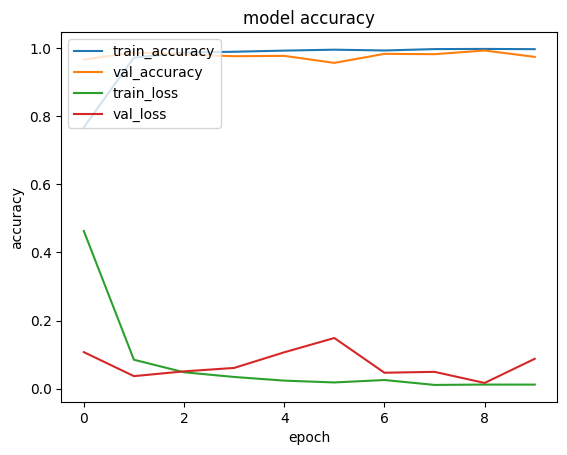

K-Fold Results:
Acuracy: 0.9463710710406303 	 +/- 0.023001698448662383
Precision: 0.9020905122160912 	 +/- 0.04957612658505849
Recall: 0.893737442791462 	 +/- 0.08426310085902362
AUC: 0.9825169075410546 	 +/- 0.012080501715207389
F1: 0.8941516036631655 	 +/- 0.03983934874494614


68/68 [==============================] - 0s 3ms/step

Test Performance:
Test Accuracy: 0.9476609826087952, Test Precision: 0.8495726585388184, Test Recall: 0.9521072506904602, Test AUC: 0.9921083797339775, Test F1 Score: 0.8979223046664304


In [12]:
# SMOTE
# BARD

k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=10, weights_path='model-weights/test_moco_BARD_6.h5', learning_rate=0.0005, num_classes=1)


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7280071973800659, Val Precision: 0.21917808055877686, Val Recall: 0.14479638636112213, Val AUC: 0.541633519632334, Val F1 Score: 0.17438692501175962
Test Accuracy: 0.7257989645004272, Test Precision: 0.3758865296840668, Test Recall: 0.20306512713432312, Test AUC: 0.6010820185508956,Test F1 Score: 0.2636815873637552

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7350427508354187, Val Precision: 0.4375, Val Recall: 0.21292775869369507, Val AUC: 0.6362107137700341, Val F1 Score: 0.2864450146333971
Test Accuracy: 0.7142195701599121, Test Precision: 0.3442623019218445, Test Recall: 0.20114941895008087, Test AUC: 0.6448846946919536,Test F1 Score: 0.2539298638001119

Training on fold 3
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.7306238412857056, Val Precision: 0.7083333134651184, Val Recall: 0.0576271191239357, Val AUC: 0.8186018615189817

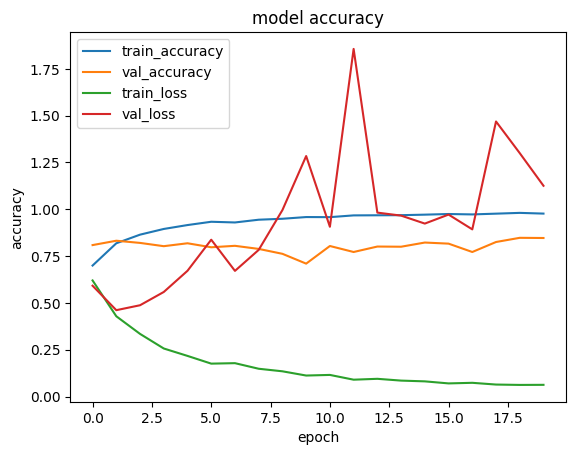

K-Fold Results:
Acuracy: 0.750789001584053 	 +/- 0.05282404198254123
Precision: 0.5406130328774452 	 +/- 0.17115483125518605
Recall: 0.23621338326483965 	 +/- 0.1320295671326956
AUC: 0.6972532352601537 	 +/- 0.08564021541352505
F1: 0.30895221949220036 	 +/- 0.1448933317725948


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.7628531455993652, Test Precision: 0.5146198868751526, Test Recall: 0.3371647596359253, Test AUC: 0.7431428858977149, Test F1 Score: 0.40740741494422156


In [13]:
# Deep SMOTE
# PTB-XL

k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=20, weights_path='model-weights/test_moco_model.h5', learning_rate=0.0005, num_classes=1, name="moco_ptbxl_deep_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.7208258509635925, Val Precision: 0.3628048896789551, Val Recall: 0.5384615659713745, Val AUC: 0.6984844415843692, Val F1 Score: 0.43351549991425775
Test Accuracy: 0.6442797780036926, Test Precision: 0.2936241626739502, Test Recall: 0.33524903655052185, Test AUC: 0.587631683038546,Test F1 Score: 0.3130590324592891

Training on fold 2
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.7350427508354187, Val Precision: 0.47752809524536133, Val Recall: 0.6463878154754639, Val AUC: 0.7587765317418298, Val F1 Score: 0.5492730183272224
Test Accuracy: 0.6729967594146729, Test Precision: 0.35975611209869385, Test Recall: 0.4521072804927826, Test AUC: 0.607623163576021,Test F1 Score: 0.40067912647821663

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.6843100190162659, Val Precision: 0.3177570104598999, Val Recall: 0.1152542382478714, Val AUC: 0.621089

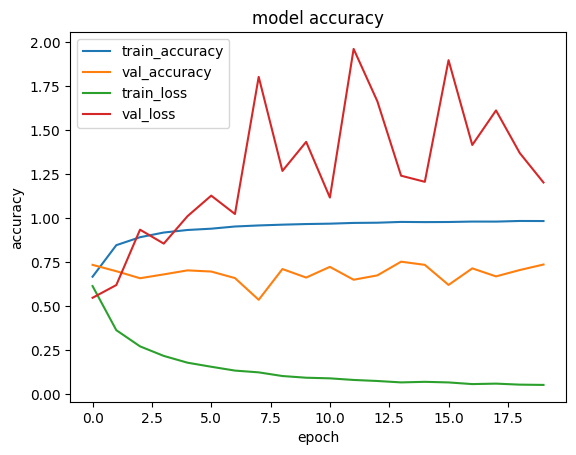

K-Fold Results:
Acuracy: 0.685550145804882 	 +/- 0.05965771612233623
Precision: 0.3650644775480032 	 +/- 0.12842929982799978
Recall: 0.30328015703707933 	 +/- 0.18649554246046
AUC: 0.6067826111583459 	 +/- 0.0949754683613055
F1: 0.30401725221814485 	 +/- 0.1376693748956854


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.6729967594146729, Test Precision: 0.35975611209869385, Test Recall: 0.4521072804927826, Test AUC: 0.607623163576021, Test F1 Score: 0.40067912647821663


In [14]:
# Deep SMOTE
# BARD

k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=20, weights_path='model-weights/test_moco_BARD_6.h5', learning_rate=0.0005, num_classes=1, name="moco_bard_deep_smote_brugada.h5")

# Auto-Encoder

In [ ]:
def encoder(inputs, latent_dim):
    # 100 x 12
    X = layers.Conv1D(24, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='conv1')(inputs)
    # 96 x 24
    X = layers.MaxPooling1D(2)(X)
    X = layers.Dropout(0.2)(X)
    # 48 x 32
    X = layers.Conv1D(48, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='conv2')(X)
    # 44 x 48
    X = layers.MaxPooling1D(2)(X)
    X = layers.Dropout(0.2)(X)
    # 22 x 48
    X = layers.Conv1D(64, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='conv3')(X)
    # 18 x 64
    X = layers.MaxPooling1D(2)(X)
    X = layers.Dropout(0.2)(X)
    # 9 x 64
    X = layers.Flatten()(X)
    # 1152
    X = layers.Dense(latent_dim, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense-encode')(X)
    # latent_dim
    return X

def decoder(latent_rep, latent_dim):
    X = layers.Dense(9*64, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense-decode')(latent_rep)
    # 1152
    X = layers.Reshape((9, 64))(X)
    # 9 x 64
    X = layers.UpSampling1D(2)(X)
    # 18 x 64
    X = layers.Conv1DTranspose(48, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='upconv1')(X)
    # 22 x 48
    X = layers.UpSampling1D(2)(X)
    # 44 x 48
    X = layers.Conv1DTranspose(24, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='upconv2')(X)
    # 48 x 24
    X = layers.UpSampling1D(2)(X)
    # 96 x 24
    X = layers.Conv1DTranspose(12, 5, activation='linear', padding='valid', name='upconv3')(X)
    # 100 x 12
    return X

def make_model(inputs, latent_dim):
    latent_rep = encoder(inputs, latent_dim)
    X = decoder(latent_rep, latent_dim)
    return keras.Model(inputs=inputs, outputs=X)

In [ ]:
def classification_head(inputs, num_classes):
    X = layers.Dense(64, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense1')(inputs)
    X = layers.Dropout(0.2)(X)
    X = layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense2')(X)
    X = layers.Dropout(0.2)(X)
    X = layers.Dense(num_classes, activation='sigmoid', name='dense3')(X)
    return X

In [ ]:
def k_fold_autoencoder_classification(k, X_train, Y_train, folds_train, X_val, Y_val, folds_val, batch_size=32, epochs=5, weights_path=None, learning_rate=0.001, num_classes=1, name="b_model.h5"):
    """Carries out k-fold cross validation for fine-tuning a ResNet model on the given data.
    
    Args:
        k (int): The number of folds to use for cross validation.
        X_train (numpy.ndarray): The training data.
        Y_train (numpy.ndarray): The training labels.
        freeze_layers (int): The number of layers to freeze in the ResNet model.
        batch_size (int): The batch size to use for training.
        epochs (int): The number of epochs to train for.
        weights_path (str): The path to the weights file to save the model to.
        learning_rate (float): The learning rate to use for training.
        num_classes (int): The number of classes in the data.
    """
    
    X_input = keras.Input(shape=X_train.shape[1:])
    
    final_history = None
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    val_aucs = []
    
    for i in range(k):
    
        train_index = np.where(folds_train != i)[0]
        val_index = np.where(folds_val == i)[0]
        
        X_train_fold, X_val_fold = X_train[train_index], X_val[val_index]
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_val[val_index]
        
        print(f"\nTraining on fold {i+1}")
        
        # make model
        enc = encoder(X_input, 256)
        classiifier = classification_head(enc, 1)
        model = keras.Model(inputs=inputs, outputs=classiifier)
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

        # load + freeze weights
        if weights_path:
            model.load_weights(weights_path, by_name=True) # 'model-weights/resnet10_simclr_model.h5'
                
        # train
        history = model.fit(X_train_fold, X_train_fold, validation_data=(X_val_fold, X_val_fold), epochs=epochs, batch_size=batch_size, verbose=0)
        
        # evaluate
        val_loss, val_accuracy = model.evaluate(X_val_fold, X_val_fold, batch_size=32, verbose=0)
        y_pred = model.predict(X_val_fold)
        val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
        val_auc = roc_auc_score(Y_val_fold, y_pred)
        
        test_loss, test_accuracy = model.evaluate(X_test, X_test, batch_size=32, verbose=0)
        y_pred = model.predict(X_test)
        test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
        test_auc = roc_auc_score(Y_test, y_pred)
        
        print(f"Val Accuracy: {val_accuracy}, Val AUC: {val_auc}, Val F1 Score: {val_f1}")
        print(f"Test Accuracy: {test_accuracy}, Test AUC: {test_auc}, Test F1 Score: {test_f1}")
        
        if not val_f1s or val_f1 > max(val_f1s):
            model.save_weights(f'model-weights/fine-tuned/{name}')
            final_history = history
            
    # plot training history
    plt.plot(final_history.history['accuracy'])
    plt.plot(final_history.history['val_accuracy'])
    plt.plot(final_history.history['loss'])
    plt.plot(final_history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'], loc='upper left')
    plt.show()
    
    # print final results
    print("K-Fold Results:")
    print(f"Acuracy: {np.mean(val_accuracies)} \t +/- {np.std(val_accuracies)}")
    print(f"Precision: {np.mean(val_precisions)} \t +/- {np.std(val_precisions)}")
    print(f"Recall: {np.mean(val_recalls)} \t +/- {np.std(val_recalls)}")
    print(f"AUC: {np.mean(val_aucs)} \t +/- {np.std(val_aucs)}")
    print(f"F1: {np.mean(val_f1s)} \t +/- {np.std(val_f1s)}")

    # load best model
    enc = encoder(X_input, 256)
    classiifier = classification_head(enc, 1)
    model = keras.Model(inputs=inputs, outputs=classiifier)
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    model.load_weights('model-weights/resnet10_simclr_model_finetuned_brugada.h5')
    
    # evaluate on test set
    print("\n") # spacer
    test_loss, test_accuracy = model.evaluate(X_test, X_test, batch_size=32)
    y_pred = model.predict(X_test)
    test_auc = roc_auc_score(Y_test, y_pred)
    print("\nTest Performance:")
    print(f"Test Accuracy: {test_accuracy}, Test AUC: {test_auc}, Test F1 Score: {test_f1}")
    
    